# COSMOS Detection pipeline

This walkthrough shows how to perform basic document region detection over PDF documents using COSMOS. We'll use a trained model to classify regions on pages into tables, equations, etc

In [17]:
%load_ext autoreload
%autoreload 2
from dask.distributed import Client
from ingest.utils.pdf_helpers import prepare_pdf_objs
from ingest.ingest import pdf_to_images
from ingest.process_page import process_page
from ingest.process.detection.src.infer import get_model
from ingest.detect import detect
from ingest.detect_setup import DetectPlugin
from ingest.utils.visualize import visualize_prediction
import matplotlib.pyplot as plt
from tqdm import tqdm
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the distributed backend

Cosmos uses Dask's lower level api, [Dask Distributed](https://distributed.dask.org/en/latest/) to handle its processing load. In this walkthrough, we'll setup a single node for processing, but this can be naturally extended to however many workers you want. Now, you can visualize your processing by clicking on the dashboard link below.

In [3]:
client = Client(serializers=['msgpack', 'dask'], deserializers=['msgpack', 'dask']) # We'll need msgpack as a serializer to fallback on
client

DEBUG:asyncio:Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector


Client Scheduler: tcp://127.0.0.1:58825 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


## Load the detection model

We load the model from pretrained weights, and supply the model config. We'll run the model on CPU, but if you have a GPU available, you can load the model to your GPU by setting the device string. To enable parallelism properly, we will load a model onto each of the workers by adding a model plugin.

In [4]:
model_config = '../cosmos/ingestion/ingest/process/configs/model_config.yaml'
weights_pth = '../cosmos/weights/model_weights.pth'
device_str = 'cpu'
plugin = DetectPlugin(model_config, weights_pth, device_str, keep_bytes=False)
client.register_worker_plugin(plugin)

/Users/ankur/Projects/Cosmos/cosmos/ingestion/ingest/process/detection/src/torch_model/model/utils/config_manager.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(fh)


===== BUILDING MODEL ======
Built backbone resnet50
Building downstream components via shape testing
done shape testing, building, attention mechanisms
built multi head attention
8, 8, 2048
super called
going to build a 131072 by 1024 matrix of weights
built embeddings
done


/Users/ankur/Projects/miniconda3/envs/cosmos/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


{'tcp://127.0.0.1:58831': {'status': 'OK'},
 'tcp://127.0.0.1:58832': {'status': 'OK'},
 'tcp://127.0.0.1:58837': {'status': 'OK'},
 'tcp://127.0.0.1:58840': {'status': 'OK'}}

## Preparing the PDF files

Next, we can prepare the PDF files. We'll use the documents in the example_docs directory, but you can point to your own documents to try it out. We also create a dataset id, which we will use to access our results later.

In [35]:
documents_directory = './MadisonBudgets'
dataset_id = 'example'
pdfs = client.submit(prepare_pdf_objs, documents_directory, dataset_id)
pdfs = pdfs.result()

## Extract the images from the pdfs

We're going to not use subtasks. As a result we're going to need to call result() to synchronize and flatten lists.

In [36]:
client.scatter(pdfs) # PDFs have lots of bytes, good to scatter them first
pdf_images = [client.submit(pdf_to_images, pdf, False, 'images') for pdf in pdfs]
pdf_images = [p.result() for p in pdf_images]
images = [i for j in pdf_images for i in j]

In [37]:
images[0]

{'bytes': 'images/2020MadisonBudget.pdf/9',
 'page_id': '2dff2c63-75d3-472f-97e2-d8e2025b45ac',
 'pdf_name': '2020MadisonBudget.pdf',
 'page_num': 9}

## Propose regions on the page

In [38]:
proposals = client.map(process_page, images)

In [39]:
proposals[0].result()

{'id': '0',
 'img_path': 'images/2020MadisonBudget.pdf/9',
 'pad_img': '/tmp/2dff2c63-75d3-472f-97e2-d8e2025b45ac.png',
 'proposals': ((87, 142, 1392, 1380),),
 'page_id': '2dff2c63-75d3-472f-97e2-d8e2025b45ac'}

## Classify the proposals

Now use the models to classify the proposals.

In [40]:
detected_objs = client.map(detect, proposals)

/Users/ankur/Projects/miniconda3/envs/cosmos/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


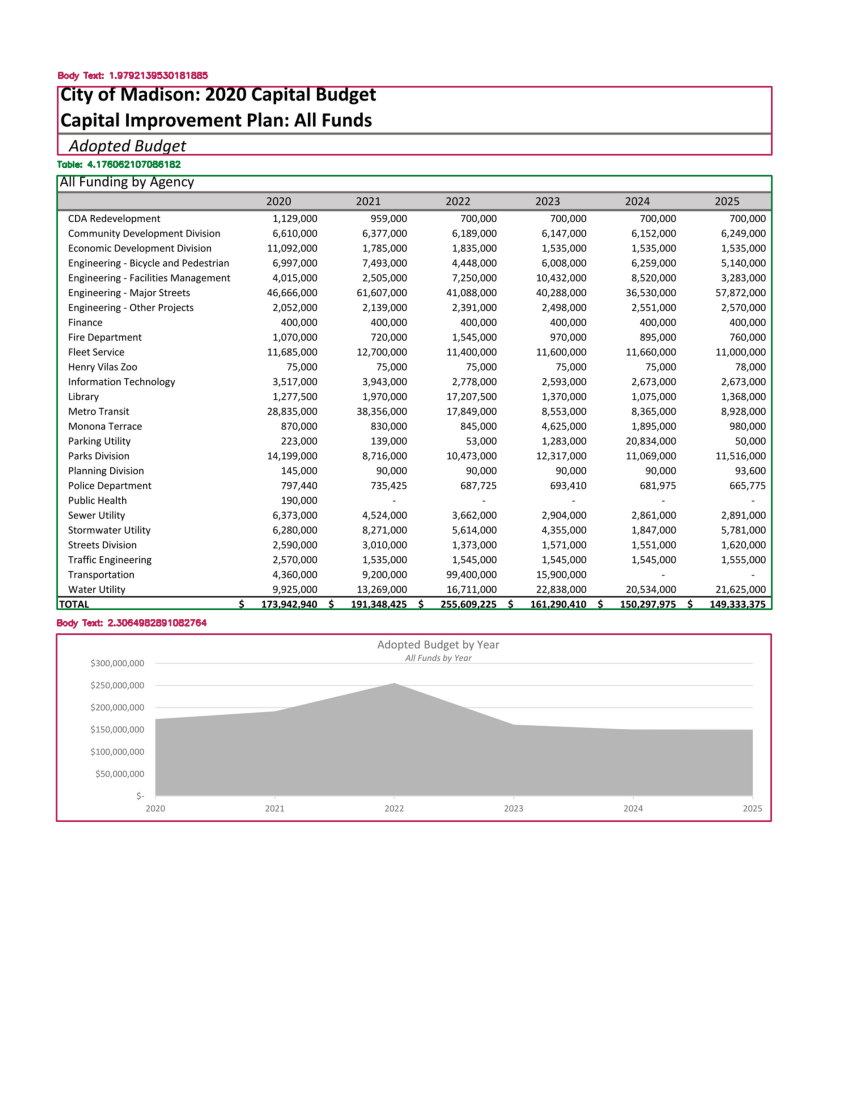

In [55]:
plt.figure(figsize = (20,20))
plt.axis('off')
r = detected_objs[11].result()
with open('../cosmos/config/classes.yaml') as rf:
    classes = yaml.load(rf)['classes']
viz = visualize_prediction(r, classes)
plt.imshow(viz)
plt.show()

And that is the minimal detection pipeline to detect tables, figures, etc. We provide additional ways to improve the model, such as an XGBoost post processing step and a rule-based postprocessing step, but that is beyond the scope of this tutorial.

{'id': '0',
 'proposals': ((346, 636, 997, 905),
  (345, 348, 1012, 615),
  (1055, 279, 1071, 294),
  (282, 1148, 1076, 1289),
  (281, 1405, 1074, 1574),
  (284, 924, 1023, 969),
  (284, 1002, 1072, 1078),
  (284, 1323, 1072, 1371),
  (285, 1111, 1014, 1130)),
 'page_id': '9c490b8b-e59a-46da-bbe8-7c969fe7a326',
 'detected_objs': (((346.0, 636.0, 997.0, 905.0),
   ((2.473278760910034, 'Figure'),
    (1.9051591157913208, 'Body Text'),
    (1.73095703125, 'Page Header'),
    (-0.7642342448234558, 'Page Footer'),
    (-1.0033196210861206, 'Equation'),
    (-1.5909558534622192, 'Figure Caption'),
    (-1.9195107221603394, 'Table'),
    (-3.237884998321533, 'Table Caption'),
    (-3.3425402641296387, 'Section Header'),
    (-4.185507297515869, 'Other'),
    (-4.748805999755859, 'Reference text'))),
  ((345.0, 348.0, 1012.0, 615.0),
   ((2.248706579208374, 'Body Text'),
    (2.1782734394073486, 'Page Header'),
    (0.2415790855884552, 'Figure'),
    (-0.3725370466709137, 'Page Footer'),
    (

In [ ]:
v = visualize_prediction(detecte)